In [1]:
#pip install tensorflow tensorflow_datasets matplotlib

In [2]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
import pickle
import matplotlib.pyplot as plt
import librosa.display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DATASET_PATH = '/content/drive/My Drive/TCC2-Gabriel/data'
OUTPUT_DIR = '/content/drive/My Drive/TCC2-Gabriel/mfcc'
MODELOS_PATH = "/content/drive/My Drive/TCC2-Gabriel/modelos_tcc/"

def process_audio(file_path):
    if not file_path.endswith('.wav'):
        raise ValueError(f"Arquivo não WAV encontrado e ignorado: {file_path}")

    audio, sample_rate = librosa.load(file_path, sr=16000, mono=True)
    audio = (audio * 32767).astype(np.int16)  # converter para 16 bits
    audio = (audio / 32768.0).astype(np.float32)  # normaliza para intervalo [-1, 1]

    return tf.convert_to_tensor(audio)

# padronizar o comprimento do áudio
def pad_audio(audio, target_length=16000):
    audio_length = tf.shape(audio)[0]
    if audio_length < target_length:
        padding = target_length - audio_length
        audio = tf.pad(audio, [[0, padding]])
    else:
        loudest_segment = extract_loudest_segment(audio)
        return loudest_segment
    return audio

# extrair o segmento mais alto
def extract_loudest_segment(audio, segment_length=16000):
    if tf.shape(audio)[0] < segment_length:
        return audio

    segments = tf.signal.frame(audio, frame_length=segment_length, frame_step=segment_length)
    energies = tf.reduce_sum(tf.square(segments), axis=1)
    max_energy_index = tf.argmax(energies)
    return segments[max_energy_index]

def load_dataset(data_dir):
    audio_data = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for audio_file in os.listdir(label_dir):
            audio_path = os.path.join(label_dir, audio_file)
            try:
                audio = process_audio(audio_path)
                padded_audio = pad_audio(audio)
                audio_data.append(padded_audio)
                labels.append(label)
            except Exception as e:
                print(f"Erro ao processar {audio_path}: {e}")
    return audio_data, labels

# carregar o dataset
audio_data, labels = load_dataset(DATASET_PATH)

In [5]:
# extrair os MFCCs (Mel-Frequency Cepstral Coefficients)
def extract_mfcc(audio, sample_rate=16000, num_mfcc=13):
    stft = tf.signal.stft(audio, frame_length=1024, frame_step=512)
    magnitude_spectrogram = tf.abs(stft)
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=40, num_spectrogram_bins=magnitude_spectrogram.shape[-1],
        sample_rate=sample_rate, lower_edge_hertz=0, upper_edge_hertz=sample_rate / 2
    )
    mel_spectrogram = tf.tensordot(magnitude_spectrogram, mel_spectrogram, 1)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
    return tf.expand_dims(mfccs[:num_mfcc], axis=-1)

def process_and_extract_features(audio_data, labels):
    features = []
    for audio in audio_data:
        mfccs = extract_mfcc(audio)
        features.append(mfccs.numpy())
    return np.array(features), np.array(labels)

# extrair as features
features, labels = process_and_extract_features(audio_data, labels)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# salvar as características e rótulos em formato Pickle como um dicionário
with open(os.path.join(OUTPUT_DIR, 'mfcc_features.pkl'), 'wb') as f:
    pickle.dump({'features': features, 'labels': labels}, f)

print("Número de amostras:", len(features))
print("Formato das características:", features.shape)

Número de amostras: 2849
Formato das características: (2849, 13, 40, 1)


Figura salva como: sinal_explosao.png


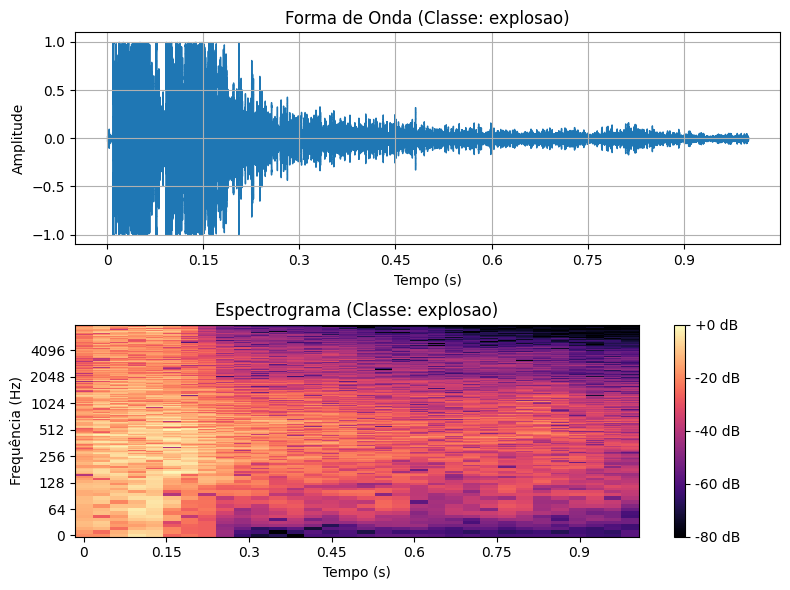

Figura salva como: sinal_cachorro.png


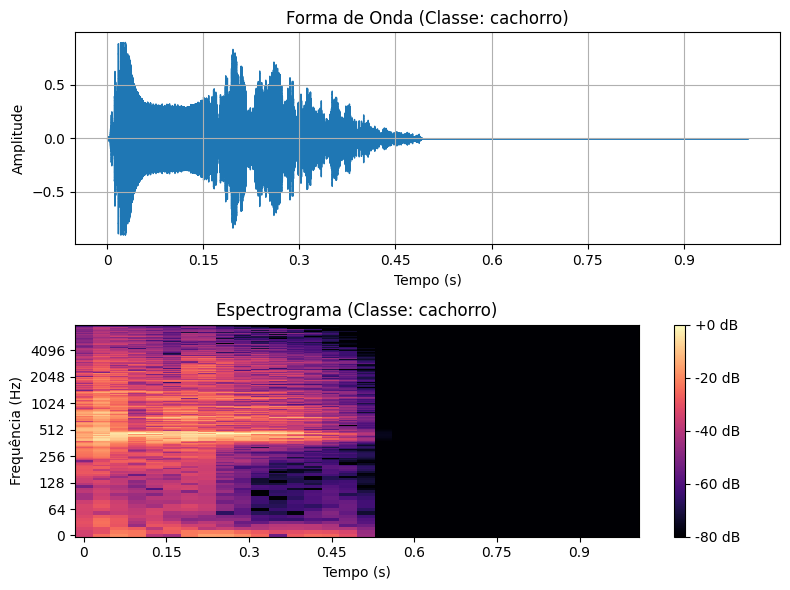

In [6]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# Função ajustada para encontrar e plotar um áudio de uma classe específica
def display_specific_class_waveform(audio_data, labels, class_name, file_name_to_save):
    """Encontra um áudio de uma classe específica, exibe e salva a figura."""

    # Encontra o primeiro índice que corresponde à classe desejada
    try:
        idx = list(labels).index(class_name)
    except ValueError:
        print(f"Classe '{class_name}' não encontrada nos dados.")
        return

    audio = audio_data[idx]
    sample_rate = 16000

    plt.figure(figsize=(8, 6))

    # Plot da Forma de Onda
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio.numpy(), sr=sample_rate)
    plt.title(f'Forma de Onda (Classe: {class_name})')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot do Espectrograma
    stft = librosa.stft(audio.numpy())
    magnitude = np.abs(stft)
    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max), sr=sample_rate, x_axis='time', y_axis='log')
    plt.title(f'Espectrograma (Classe: {class_name})')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')

    plt.tight_layout()
    plt.savefig(file_name_to_save)
    print(f"Figura salva como: {file_name_to_save}")
    plt.show()

# Gerar e salvar a imagem para a classe "explosao"
display_specific_class_waveform(audio_data, labels, 'explosao', 'sinal_explosao.png')

# Gerar e salvar a imagem para a classe "cachorro"
display_specific_class_waveform(audio_data, labels, 'cachorro', 'sinal_cachorro.png')

Exibindo áudio do rótulo: sirene / 2579


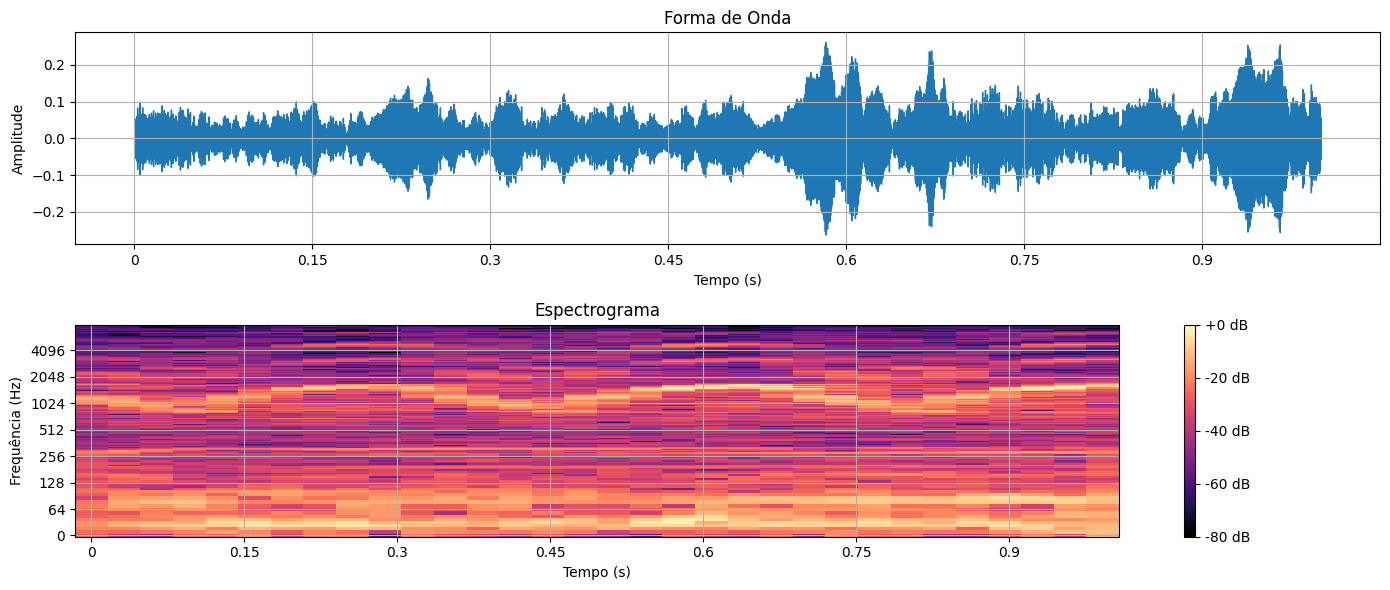

In [7]:
# Função para exibir a forma de onda e o espectrograma
def display_waveform_and_spectrogram(audio, sample_rate=16000):
    plt.figure(figsize=(14, 6))

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio.numpy(), sr=sample_rate)
    plt.title('Forma de Onda')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid()

    stft = librosa.stft(audio.numpy())
    magnitude = np.abs(stft)
    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max), sr=sample_rate, x_axis='time', y_axis='log')
    plt.title('Espectrograma')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.grid()

    plt.tight_layout()
    plt.show()

# exibir a forma de onda e o espectrograma de um arquivo aleatório
def display_random_waveform_and_spectrogram(audio_data, labels):
    index = random.randint(0, len(audio_data) - 1)
    audio = audio_data[index]
    label = labels[index]

    print(f"Exibindo áudio do rótulo: {label} / {index}")
    display_waveform_and_spectrogram(audio)


display_random_waveform_and_spectrogram(audio_data, labels)

In [8]:
from sklearn.preprocessing import LabelEncoder

with open('/content/drive/My Drive/TCC2-Gabriel/mfcc/mfcc_features.pkl', 'rb') as file:
    dados_carregados = pickle.load(file)

X = dados_carregados['features']
y = dados_carregados['labels']
print(y)

# codificar os rótulos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(y_encoded)

['buzina' 'buzina' 'buzina' ... 'tiro' 'tiro' 'tiro']
[0 0 0 ... 8 8 8]


In [9]:
from sklearn.model_selection import train_test_split

# Divisão em treino (80%) e um conjunto temporário (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.2,      # 20% para o conjunto temporário
    stratify=y_encoded, # Stratificação para manter a proporção das classes
    random_state=42
)

# Divisão do conjunto temporário em validação (10%) e teste (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,      # 50% do conjunto temporário para teste
    stratify=y_temp,    # Mantém a proporção das classes
    random_state=42
)

print("Tamanho do conjunto de treinamento:", len(X_train))
print("Tamanho do conjunto de validação:", len(X_val))
print("Tamanho do conjunto de teste:", len(X_test))

Tamanho do conjunto de treinamento: 2279
Tamanho do conjunto de validação: 285
Tamanho do conjunto de teste: 285


In [10]:
# Converter para tensores do TensorFlow
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Criar datasets do TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# configurar o dataset
def prepare_dataset(dataset, batch_size=64, is_train=False):
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.shuffle(1000)
    return dataset.prefetch(tf.data.AUTOTUNE)

train_ds = prepare_dataset(train_dataset, is_train=True)
val_ds = prepare_dataset(val_dataset)
test_ds = prepare_dataset(test_dataset)

num_classes = len(label_encoder.classes_)

class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapeamento de classes:", class_mapping)

Mapeamento de classes: {np.str_('buzina'): np.int64(0), np.str_('cachorro'): np.int64(1), np.str_('colisao'): np.int64(2), np.str_('explosao'): np.int64(3), np.str_('freio'): np.int64(4), np.str_('grito'): np.int64(5), np.str_('outros'): np.int64(6), np.str_('sirene'): np.int64(7), np.str_('tiro'): np.int64(8)}


---
# Modelo 1: CNN 2D (Modelo Base)

Esta seção define a arquitetura de referência (*baseline*) do estudo, uma Rede Neural Convolucional (CNN) 2D customizada. O modelo foi projetado para extrair padrões espaciais e hierárquicos dos espectrogramas MFCC, servindo como um ponto de comparação robusto para as outras arquiteturas.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 12, 39, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 39, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 19, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 19, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 18, 64)      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 18, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 8, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,569 (306.91 KB)

 Trainable params: 77,609 (303.16 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2282 - loss: 2.8593 - val_accuracy: 0.5368 - val_loss: 1.6836
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.4771 - loss: 1.8329 - val_accuracy: 0.4632 - val_loss: 1.5406
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4991 - loss: 1.6661 - val_accuracy: 0.4386 - val_loss: 1.6695
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5460 - loss: 1.5550 - val_accuracy: 0.4211 - val_loss: 1.8053
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5933 - loss: 1.3642 - val_accuracy: 0.4667 - val_loss: 1.6496
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6057 - loss: 1.3138 - val_accuracy: 0.4912 - val_loss: 1.5198
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6072 - loss: 1.2214 - val_accuracy: 0.5053 - val_loss: 1.5089
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6273 - loss: 1.2105 - val_accuracy: 0.

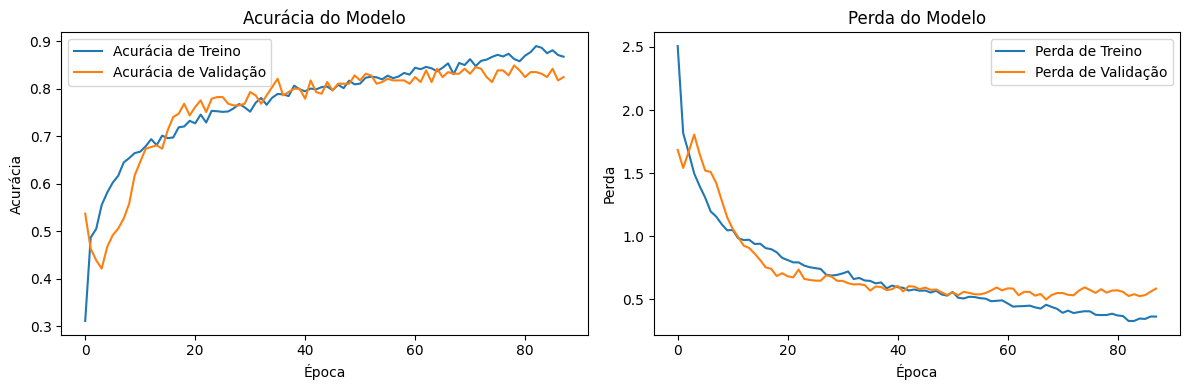

In [11]:
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # 1ª camada
        layers.Conv2D(32, kernel_size=(2, 2), activation='relu',
                      input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # 2ª camada
        layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # 3ª camada
        layers.Conv2D(128, kernel_size=(2, 2), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalMaxPooling2D(),
        layers.Dropout(0.25),

        # Camadas densas
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Camada de saída
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Definir a forma de entrada corretamente
input_shape = (X_train.shape[1], X_train.shape[2], 1)

num_classes = len(np.unique(y))

model = create_cnn_model(input_shape, num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
model.summary()

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= MODELOS_PATH + 'best_model_cnn.keras',
    monitor='val_accuracy',
    save_best_only=True
)

# Treinamento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint]
)

# Avaliar no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plotar histórico de treinamento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plotar acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Plotar perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

      buzina     0.8235    0.6087    0.7000        23
    cachorro     0.8889    0.7742    0.8276        31
     colisao     0.7857    0.8462    0.8148        13
    explosao     0.8000    0.7500    0.7742        16
       freio     0.5833    0.4667    0.5185        15
       grito     1.0000    0.4737    0.6429        19
      outros     0.8209    0.9821    0.8943       112
      sirene     0.8000    0.8000    0.8000        30
        tiro     0.8148    0.8462    0.8302        26

    accuracy                         0.8175       285
   macro avg     0.8130    0.7275    0.7558       285
weighted avg     0.8224    0.8175    0.8087       285



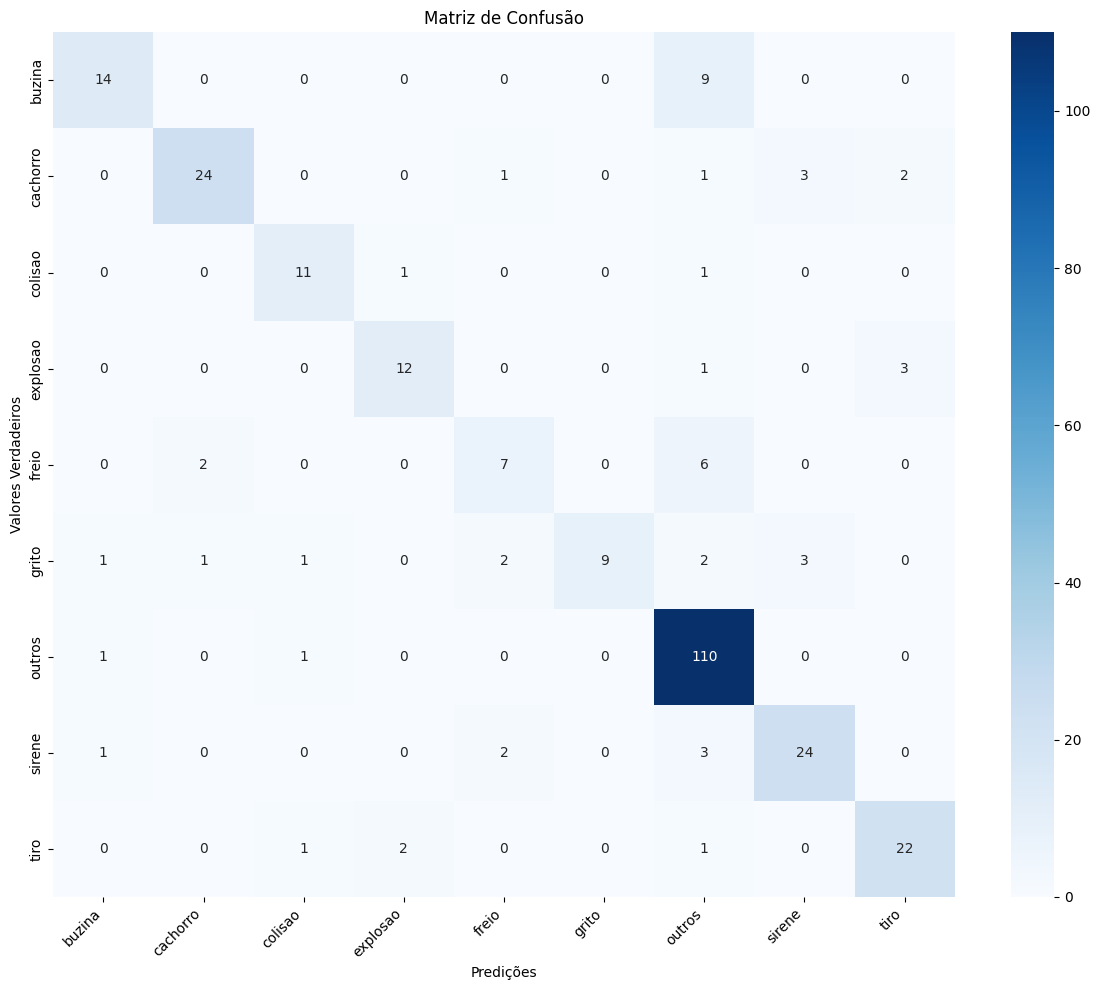


Métricas Globais:
Precisão Geral: 0.8224
Recall Geral: 0.8175
F1-Score Geral: 0.8087

Número de amostras mal classificadas: 52

Detalhes de Classificações Incorretas:
Índice: 5, Real: explosao, Predito: tiro
Índice: 6, Real: tiro, Predito: outros
Índice: 10, Real: buzina, Predito: outros
Índice: 12, Real: grito, Predito: freio
Índice: 20, Real: grito, Predito: outros
Índice: 34, Real: cachorro, Predito: tiro
Índice: 35, Real: freio, Predito: cachorro
Índice: 38, Real: grito, Predito: buzina
Índice: 42, Real: freio, Predito: outros
Índice: 49, Real: freio, Predito: outros

Distribuição de Erros por Classe:

explosao:
  - Predito como tiro: 3 vezes
  - Predito como outros: 1 vezes

tiro:
  - Predito como outros: 1 vezes
  - Predito como colisao: 1 vezes
  - Predito como explosao: 2 vezes

buzina:
  - Predito como outros: 9 vezes

grito:
  - Predito como freio: 2 vezes
  - Predito como outros: 2 vezes
  - Predito como buzina: 1 vezes
  - Predito como sirene: 3 vezes
  - Predito como cach

In [12]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin

label_names = ['buzina', 'cachorro', 'colisao', 'explosao', 'freio',
               'grito', 'outros', 'sirene', 'tiro']

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=10):
        self.model = model
        self.epochs = epochs

    def fit(self, X, y):
        if len(y.shape) == 1:
            y = tf.keras.utils.to_categorical(y)

        self.model.fit(X, y, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Carregar o melhor modelo do Google Drive
best_model = tf.keras.models.load_model(MODELOS_PATH + 'best_model_cnn.keras')

# Fazer predições
y_pred_prob = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Extrair labels verdadeiros do dataset de teste
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 1. Relatório de Classificação Detalhado
print("Relatório de Classificação Detalhado:")
print(classification_report(y_true, y_pred,
                            target_names=label_names,
                            digits=4))

# 2. Matriz de Confusão
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Matriz de Confusão')
plt.xlabel('Predições')
plt.ylabel('Valores Verdadeiros')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Métricas Detalhadas
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted')

print(f"\nMétricas Globais:")
print(f"Precisão Geral: {precision:.4f}")
print(f"Recall Geral: {recall:.4f}")
print(f"F1-Score Geral: {f1_score:.4f}")

# 5. Análise de Erros
misclassified_indices = np.where(y_true != y_pred)[0]
print(f"\nNúmero de amostras mal classificadas: {len(misclassified_indices)}")

# Detalhes de classificações incorretas
print("\nDetalhes de Classificações Incorretas:")
for idx in misclassified_indices[:10]:  # primeiros 10 erros
    print(f"Índice: {idx}, Real: {label_names[y_true[idx]]}, Predito: {label_names[y_pred[idx]]}")

# Distribuição de Erros por Classe
erro_por_classe = {}
for idx in misclassified_indices:
    classe_real = label_names[y_true[idx]]
    classe_predita = label_names[y_pred[idx]]

    if classe_real not in erro_por_classe:
        erro_por_classe[classe_real] = {}

    if classe_predita not in erro_por_classe[classe_real]:
        erro_por_classe[classe_real][classe_predita] = 0

    erro_por_classe[classe_real][classe_predita] += 1

print("\nDistribuição de Erros por Classe:")
for classe_real, predicoes in erro_por_classe.items():
    print(f"\n{classe_real}:")
    for classe_predita, count in predicoes.items():
        if classe_real != classe_predita:
            print(f"  - Predito como {classe_predita}: {count} vezes")

In [13]:
def testar_arquivo_aleatorio(modelo, test_ds, label_names, mostrar_audio=True):
    """
    Testa um arquivo aleatório do conjunto de teste

    Parâmetros:
    - modelo: Modelo treinado
    - test_ds: Dataset de teste
    - label_names: Nomes das classes
    - mostrar_audio: Plota o espectrograma do áudio
    """
    # converter o dataset para lista
    test_data = list(test_ds.as_numpy_iterator())

    import random

    # selecionar um unico exemplo
    arquivo_teste = random.choice(test_data)
    audio_batch, label_batch = arquivo_teste

    indice = random.randint(0, len(audio_batch) - 1)
    audio = audio_batch[indice]
    label_true = label_batch[indice]

    # Adicionar dimensão de batch para o modelo
    audio_input = np.expand_dims(audio, axis=0)

    # Fazer a predição
    predicao_prob = modelo.predict(audio_input)
    label_pred = np.argmax(predicao_prob, axis=1)[0]

    # Plotar o áudio
    plt.figure(figsize=(15, 5))

    # subplot 1: Espectrograma
    plt.subplot(1, 2, 1)
    plt.imshow(audio, aspect='auto', origin='lower')
    plt.title('Espectrograma do Áudio')
    plt.xlabel('Tempo')
    plt.ylabel('Frequência')

    # subplot 2: Resultados da Classificação
    plt.subplot(1, 2, 2)

    # Preparar dados para gráfico de barras de probabilidades
    probs = predicao_prob[0]

    plt.bar(label_names, probs)
    plt.title('Probabilidades de Classificação')
    plt.xlabel('Classes')
    plt.ylabel('Probabilidade')
    plt.xticks(rotation=45, ha='right')

    # Adicionar informações de predição
    plt.text(0.5, -0.45,
             f'Label Verdadeira: {label_names[label_true]}\n' +
             f'Label Predita: {label_names[label_pred]}\n' +
             f'Predição Correta: {"Sim" if label_true == label_pred else "Não"}',
             horizontalalignment='center',
             verticalalignment='center',
             transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    print("\nDetalhes da Predição:")
    print(f"Label Verdadeira: {label_names[label_true]}")
    print(f"Label Predita: {label_names[label_pred]}")
    print("\nProbabilidades por Classe:")
    for nome, prob in zip(label_names, probs):
        print(f"{nome}: {prob*100:.2f}%")

    return {
        'label_true': label_names[label_true],
        'label_pred': label_names[label_pred],
        'probabilities': dict(zip(label_names, probs)),
        'is_correct': label_true == label_pred
    }

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


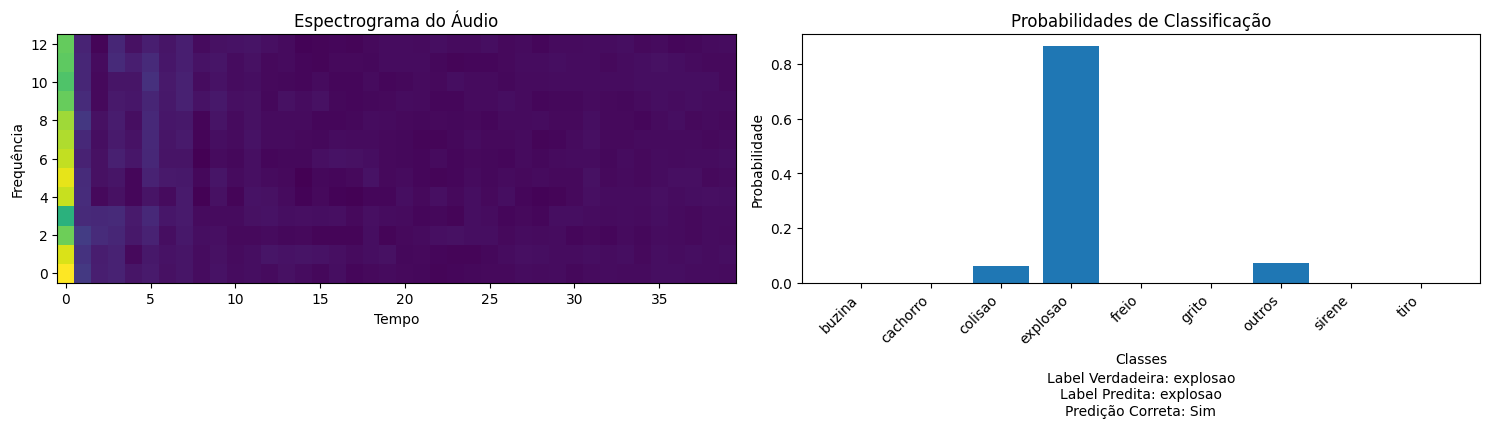


Detalhes da Predição:
Label Verdadeira: explosao
Label Predita: explosao

Probabilidades por Classe:
buzina: 0.01%
cachorro: 0.00%
colisao: 6.07%
explosao: 86.56%
freio: 0.00%
grito: 0.00%
outros: 7.35%
sirene: 0.00%
tiro: 0.01%


In [14]:
resultado = testar_arquivo_aleatorio(best_model, test_ds, label_names)

---
# Modelo 2: Rede Neural Média (MLP)

Este modelo é uma arquitetura mais simples, baseada em camadas densas (Perceptron de Múltiplas Camadas), para servir como um comparativo à abordagem convolucional. Ele avalia o desempenho da classificação utilizando apenas as features dos MFCCs, sem considerar suas relações espaciais.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 520)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        66,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,297 (298.04 KB)

 Trainable params: 75,913 (296.54 KB)

 Non-trainable params: 384 (1.50 KB)


Iniciando o treinamento do modelo MLP...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1595 - loss: 2.9698 - val_accuracy: 0.2807 - val_loss: 2.2062
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4376 - loss: 1.8214 - val_accuracy: 0.4140 - val_loss: 1.7485
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5330 - loss: 1.6127 - val_accuracy: 0.6140 - val_loss: 1.1857
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5784 - loss: 1.3237 - val_accuracy: 0.6702 - val_loss: 1.0537
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6437 - loss: 1.1908 - val_accuracy: 0.6912 - val_loss: 0.9877
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6505 - loss: 1.1519 - val_accuracy: 0.7333 - val_loss: 0.9182
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6750 - loss: 1.0633 - val_accuracy: 0.7439 - val_loss: 0.8752
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.

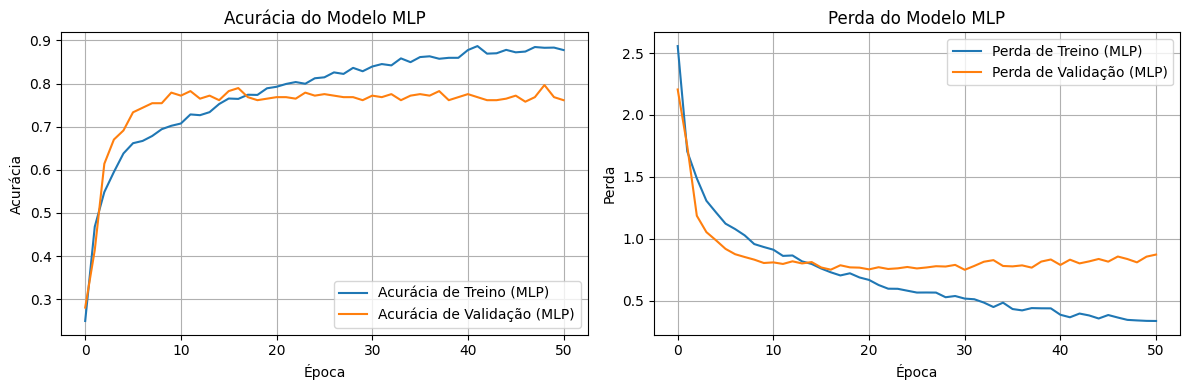

In [15]:
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 1. Definição da Arquitetura MLP
def create_mlp_model(input_shape, num_classes):
    model = models.Sequential([
        # Camada de entrada que achata os MFCCs de (13, 40, 1) para um vetor
        layers.Flatten(input_shape=input_shape),

        # 1ª Camada Densa
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # 2ª Camada Densa
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Camada de Saída
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# A forma de entrada é a mesma do modelo CNN
input_shape = (X_train.shape[1], X_train.shape[2], 1)
num_classes = len(label_encoder.classes_)

# Criar e compilar o modelo MLP
mlp_model = create_mlp_model(input_shape, num_classes)

# Usar o mesmo otimizador e função de perda para uma comparação justa
mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
mlp_model.summary()

# 2. Treinamento do Modelo MLP
# Reutilizar os mesmos callbacks, mas com um novo nome de arquivo para o checkpoint
mlp_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= MODELOS_PATH + 'best_model_mlp.keras',
    monitor='val_accuracy',
    save_best_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20, # A mesma paciência do modelo anterior
    restore_best_weights=True
)

print("\nIniciando o treinamento do modelo MLP...")

history_mlp = mlp_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100, # O mesmo número de épocas
    callbacks=[early_stopping, mlp_model_checkpoint]
)

# 3. Avaliação no Conjunto de Teste
print("\nAvaliando o modelo MLP no conjunto de teste...")
test_loss_mlp, test_accuracy_mlp = mlp_model.evaluate(test_ds)
print(f"Acurácia no teste (MLP): {test_accuracy_mlp:.4f}")

# 4. Plotar Curvas de Aprendizado
plt.figure(figsize=(12, 4))

# Plotar acurácia
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['accuracy'], label='Acurácia de Treino (MLP)')
plt.plot(history_mlp.history['val_accuracy'], label='Acurácia de Validação (MLP)')
plt.title('Acurácia do Modelo MLP')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Plotar perda
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['loss'], label='Perda de Treino (MLP)')
plt.plot(history_mlp.history['val_loss'], label='Perda de Validação (MLP)')
plt.title('Perda do Modelo MLP')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('curva_mlp.png')
plt.show()

Carregando o melhor modelo MLP para análise detalhada...
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Relatório de Classificação do Modelo MLP:
              precision    recall  f1-score   support

      buzina     0.8750    0.6087    0.7179        23
    cachorro     0.9032    0.9032    0.9032        31
     colisao     0.5556    0.7692    0.6452        13
    explosao     0.6923    0.5625    0.6207        16
       freio     0.6250    0.6667    0.6452        15
       grito     0.7273    0.4211    0.5333        19
      outros     0.8293    0.9107    0.8681       112
      sirene     0.8438    0.9000    0.8710        30
        tiro     0.7200    0.6923    0.7059        26

    accuracy                         0.7930       285
   macro avg     0.7524    0.7149    0.7234       285
weighted avg     0.7948    0.7930    0.7872       285



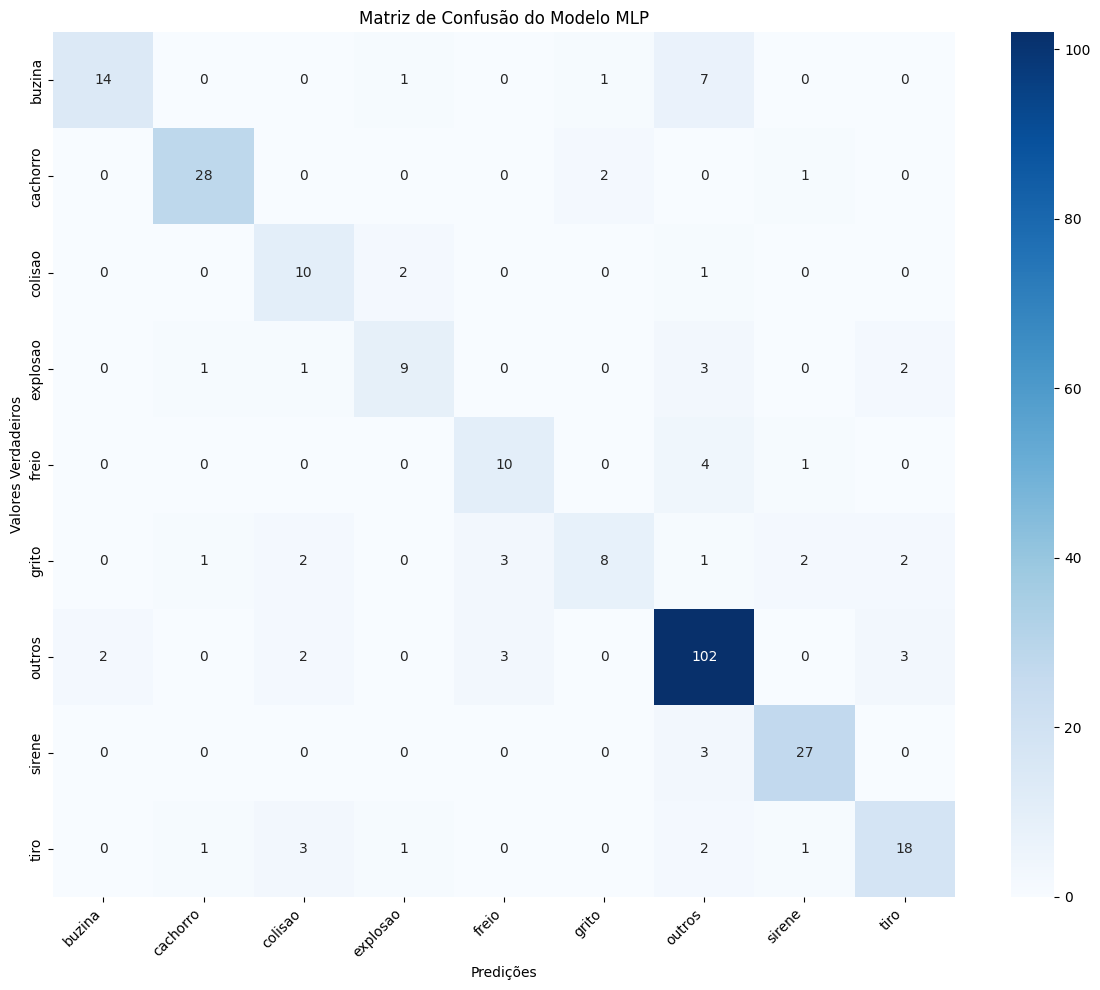

In [16]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

label_names = ['buzina', 'cachorro', 'colisao', 'explosao', 'freio',
               'grito', 'outros', 'sirene', 'tiro']

print("Carregando o melhor modelo MLP para análise detalhada...")
best_mlp_model = tf.keras.models.load_model(MODELOS_PATH + 'best_model_mlp.keras')

# Fazer predições no conjunto de teste
y_pred_prob_mlp = best_mlp_model.predict(test_ds)
y_pred_mlp = np.argmax(y_pred_prob_mlp, axis=1)

# y_true já foi extraído na análise do modelo CNN
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Relatório de Classificação
print("\nRelatório de Classificação do Modelo MLP:")
print(classification_report(y_true, y_pred_mlp, target_names=label_names, digits=4))

# Matriz de Confusão
plt.figure(figsize=(12, 10))
cm_mlp = confusion_matrix(y_true, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Matriz de Confusão do Modelo MLP')
plt.xlabel('Predições')
plt.ylabel('Valores Verdadeiros')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('matriz_mlp.png')
plt.show()

---
# Modelo 3: Rede Neural Residual (ResNet-18)

Implementação de uma arquitetura ResNet-18 padrão, construída do zero (*trained from scratch*) para se adaptar às dimensões dos espectrogramas de entrada ($13 \times 40$). Este modelo, mais profundo que a CNN base, é utilizado para avaliar o impacto de uma maior complexidade arquitetural e das conexões residuais no desempenho da classificação.

In [17]:
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Definição do Bloco Residual Básico (para ResNet-18/34)
def residual_block(x, filters, strides=(1, 1)):
    """Cria um bloco residual padrão da ResNet."""
    shortcut = x

    # Primeira camada convolucional do bloco
    y = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    # Segunda camada convolucional do bloco
    y = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)

    # A conexão de atalho (shortcut) precisa ter as mesmas dimensões da saída do bloco
    # Se as dimensões mudaram (strides > 1), aplicamos uma convolução 1x1 no atalho
    if strides != (1, 1) or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Adiciona o atalho à saída do bloco
    y = layers.Add()([y, shortcut])
    y = layers.Activation('relu')(y)
    return y

# 2. Definição da Arquitetura ResNet-18
def create_resnet18_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Camada inicial (Stem)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Pilha de Blocos Residuais - Estrutura da ResNet-18: [2, 2, 2, 2] blocos
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, strides=(2, 2))
    x = residual_block(x, 128)

    x = residual_block(x, 256, strides=(2, 2))
    x = residual_block(x, 256)

    x = residual_block(x, 512, strides=(2, 2))
    x = residual_block(x, 512)

    # Camada Final (Head)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# A forma de entrada é a original de 1 canal
input_shape = (X_train.shape[1], X_train.shape[2], 1)
num_classes = len(label_encoder.classes_)

# Criar e compilar o modelo ResNet-18
resnet18_model = create_resnet18_model(input_shape, num_classes)

# Usar a mesma configuração da CNN base para uma comparação justa
resnet18_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

resnet18_model.summary()

# 3. Treinamento do Modelo ResNet-18
resnet18_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= MODELOS_PATH + 'best_model_resnet18.keras',
    monitor='val_accuracy',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)

print("\\nIniciando o treinamento do modelo ResNet-18...")
history_resnet18 = resnet18_model.fit(
    train_ds, # Usando o dataset original
    validation_data=val_ds, # Usando o dataset original
    epochs=100, # Pode precisar de mais épocas, mas o EarlyStopping cuidará disso
    callbacks=[early_stopping, resnet18_model_checkpoint]
)

# 4. Avaliação e Análise
print("\\nCarregando o melhor modelo ResNet-18 para análise...")
best_resnet18_model = tf.keras.models.load_model(MODELOS_PATH + 'best_model_resnet18.keras')

print("\\nAvaliando no conjunto de teste...")
test_loss_resnet18, test_accuracy_resnet18 = best_resnet18_model.evaluate(test_ds)
print(f"Acurácia no teste (ResNet-18): {test_accuracy_resnet18:.4f}")



Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 13, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 20, 64) │      3,200 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 20, 64) │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 7, 20, 64) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 10, 64) │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 10, 64) │     36,928 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 10, 64) │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 4, 10, 64) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 10, 64) │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 10, 64) │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4, 10, 64) │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 4, 10, 64) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 10, 64) │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 10, 64) │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 4, 10, 64) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 10, 64) │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 10, 64) │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 10, 64) │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,189,257 (42.68 MB)

 Trainable params: 11,179,657 (42.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

\nIniciando o treinamento do modelo ResNet-18...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - accuracy: 0.4982 - loss: 1.8078 - val_accuracy: 0.3614 - val_loss: 2.1278
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.7457 - loss: 0.7633 - val_accuracy: 0.6281 - val_loss: 1.2827
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.8234 - loss: 0.5639 - val_accuracy: 0.7018 - val_loss: 0.9365
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.8402 - loss: 0.5087 - val_accuracy: 0.6842 - val_loss: 1.0754
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.8822 - loss: 0.3400 - val_accuracy: 0.7088 - val_loss: 0.9023
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.8877 - loss: 0.3356 - val_accuracy: 0.7298 - val_loss: 0.9753
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - accuracy: 0.9326 - loss: 0.2311 - val_accuracy: 0.8281 - val_loss: 0.6053
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - a

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step
\nRelatório de Classificação do Modelo ResNet-18:
              precision    recall  f1-score   support

      buzina     0.9444    0.7391    0.8293        23
    cachorro     0.9643    0.8710    0.9153        31
     colisao     0.6250    0.7692    0.6897        13
    explosao     0.9000    0.5625    0.6923        16
       freio     0.7778    0.4667    0.5833        15
       grito     0.7222    0.6842    0.7027        19
      outros     0.9016    0.9821    0.9402       112
      sirene     0.8056    0.9667    0.8788        30
        tiro     0.8929    0.9615    0.9259        26

    accuracy                         0.8667       285
   macro avg     0.8371    0.7781    0.7953       285
weighted avg     0.8698    0.8667    0.8608       285



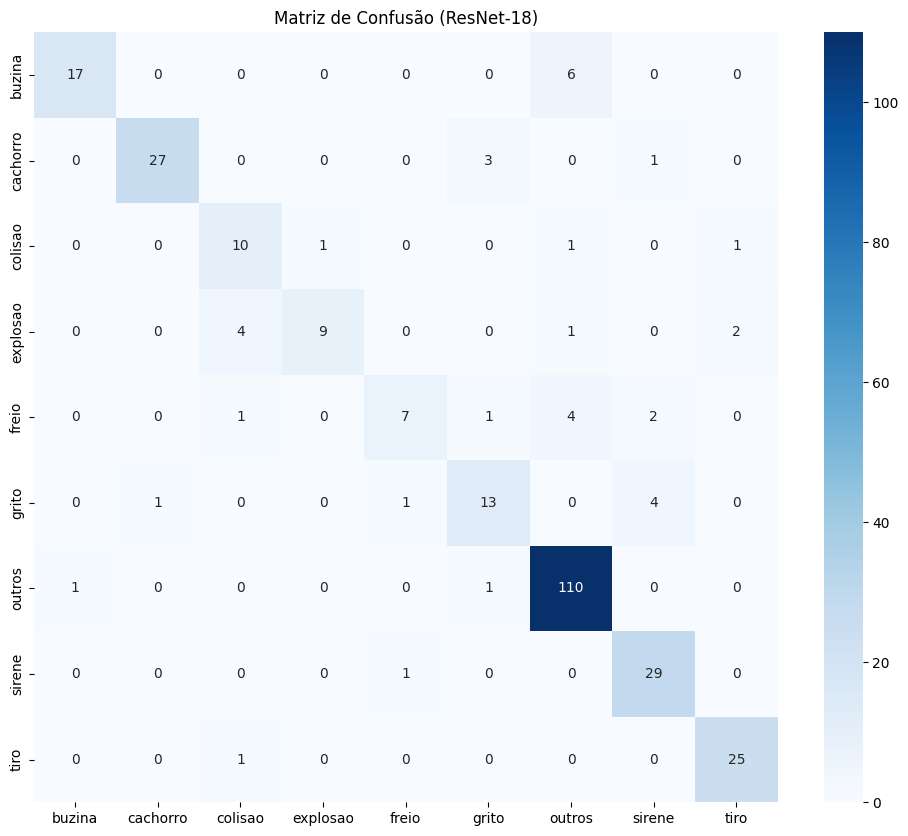

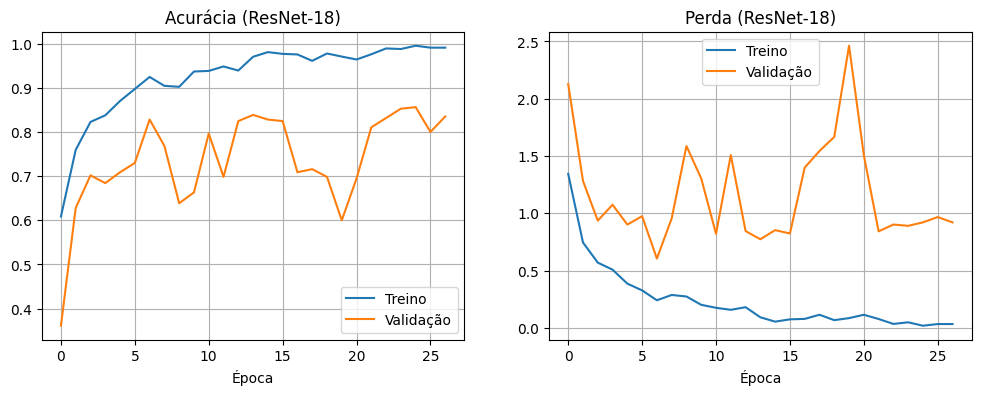

In [18]:
# Relatório e Matriz de Confusão
y_pred_prob_resnet18 = best_resnet18_model.predict(test_ds)
y_pred_resnet18 = np.argmax(y_pred_prob_resnet18, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("\\nRelatório de Classificação do Modelo ResNet-18:")
print(classification_report(y_true, y_pred_resnet18, target_names=label_names, digits=4))

plt.figure(figsize=(12, 10))
cm_resnet18 = confusion_matrix(y_true, y_pred_resnet18)
sns.heatmap(cm_resnet18, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Matriz de Confusão (ResNet-18)')
plt.savefig('matriz_resnet18.png')
plt.show()

# Curvas de Aprendizado
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet18.history['accuracy'], label='Treino')
plt.plot(history_resnet18.history['val_accuracy'], label='Validação')
plt.title('Acurácia (ResNet-18)')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history_resnet18.history['loss'], label='Treino')
plt.plot(history_resnet18.history['val_loss'], label='Validação')
plt.title('Perda (ResNet-18)')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.savefig('curva_resnet18.png')
plt.show()

---
# Modelo 4: Rede Neural Residual (ResNet-50)

Nesta seção, uma arquitetura ResNet-50 ainda mais profunda, baseada em blocos de gargalo (*bottleneck blocks*), é implementada e treinada do zero. O objetivo é testar o limite de performance com um aumento significativo na complexidade do modelo (número de camadas e parâmetros) em relação ao tamanho do dataset, permitindo analisar o trade-off entre capacidade do modelo e risco de sobreajuste.

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 13, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 7, 20, 64) │      3,200 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 20, 64) │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 7, 20, 64) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 10, 64) │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 4, 10, 64) │      4,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 10, 64) │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 4, 10, 64) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 4, 10, 64) │     36,928 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 10, 64) │        256 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 4, 10, 64) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 4, 10,     │     16,640 │ activation_19[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 4, 10,     │     16,640 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 10,     │      1,024 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 10,     │      1,024 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 4, 10,     │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 4, 10,     │          0 │ add_8[0][0]       │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 4, 10, 64) │     16,448 │ activation_20[0]

 Total params: 23,599,881 (90.03 MB)

 Trainable params: 23,546,761 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

\nIniciando o treinamento do modelo ResNet-50...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 345s 8s/step - accuracy: 0.4347 - loss: 2.7915 - val_accuracy: 0.4140 - val_loss: 1.8908
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 322s 8s/step - accuracy: 0.5969 - loss: 1.5147 - val_accuracy: 0.3930 - val_loss: 2.2982
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 314s 8s/step - accuracy: 0.7155 - loss: 1.0292 - val_accuracy: 0.3930 - val_loss: 2.4828
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 326s 8s/step - accuracy: 0.7469 - loss: 0.9109 - val_accuracy: 0.3930 - val_loss: 3.0674
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 319s 8s/step - accuracy: 0.7856 - loss: 0.6975 - val_accuracy: 0.3930 - val_loss: 3.0861
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 297s 8s/step - accuracy: 0.8513 - loss: 0.4297 - val_accuracy: 0.4386 - val_loss: 2.1729
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 305s 8s/step - accuracy: 0.8862 - loss: 0.3391 - val_accuracy: 0.5614 - val_loss: 1.6520
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 300s 8s/step - a

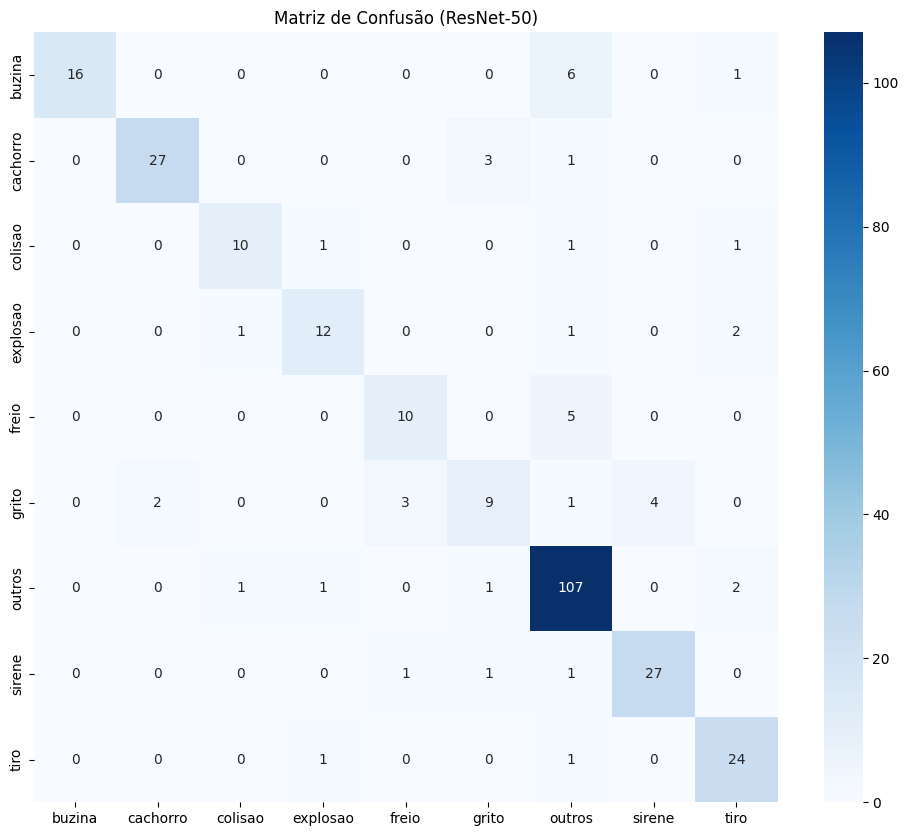

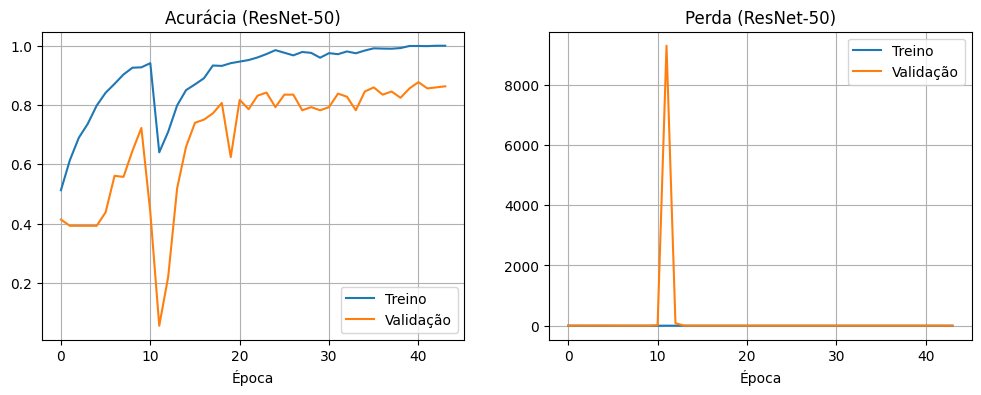

In [19]:
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Definição do Bloco de Gargalo (Bottleneck Block) para ResNet-50
def bottleneck_block(x, filters, strides=(1, 1)):
    """Cria um bloco de gargalo da ResNet-50."""
    shortcut = x

    # Camada 1: Convolução 1x1 para reduzir a dimensão
    y = layers.Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    # Camada 2: Convolução 3x3 principal
    y = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    # Camada 3: Convolução 1x1 para expandir a dimensão
    y = layers.Conv2D(filters * 4, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)

    # A conexão de atalho (shortcut) precisa ter as mesmas dimensões da saída do bloco
    if strides != (1, 1) or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Adiciona o atalho à saída do bloco
    y = layers.Add()([y, shortcut])
    y = layers.Activation('relu')(y)
    return y

# 2. Definição da Arquitetura ResNet-50
def create_resnet50_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Camada inicial (Stem)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Pilha de Blocos Residuais - Estrutura da ResNet-50: [3, 4, 6, 3] blocos
    x = bottleneck_block(x, 64)
    x = bottleneck_block(x, 64)
    x = bottleneck_block(x, 64)

    x = bottleneck_block(x, 128, strides=(2, 2))
    x = bottleneck_block(x, 128)
    x = bottleneck_block(x, 128)
    x = bottleneck_block(x, 128)

    x = bottleneck_block(x, 256, strides=(2, 2))
    x = bottleneck_block(x, 256)
    x = bottleneck_block(x, 256)
    x = bottleneck_block(x, 256)
    x = bottleneck_block(x, 256)
    x = bottleneck_block(x, 256)

    x = bottleneck_block(x, 512, strides=(2, 2))
    x = bottleneck_block(x, 512)
    x = bottleneck_block(x, 512)

    # Camada Final (Head)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# A forma de entrada é a original de 1 canal
input_shape = (X_train.shape[1], X_train.shape[2], 1)
num_classes = len(label_encoder.classes_)

# Criar e compilar o modelo ResNet-50
resnet50_model = create_resnet50_model(input_shape, num_classes)

resnet50_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

resnet50_model.summary()

# 3. Treinamento do Modelo ResNet-50
resnet50_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= MODELOS_PATH + 'best_model_resnet50_custom.keras',
    monitor='val_accuracy',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)

print("\\nIniciando o treinamento do modelo ResNet-50...")
history_resnet50 = resnet50_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, resnet50_model_checkpoint]
)

# 4. Avaliação e Análise
print("\\nCarregando o melhor modelo ResNet-50 para análise...")
best_resnet50_model = tf.keras.models.load_model(MODELOS_PATH + 'best_model_resnet50_custom.keras')

print("\\nAvaliando no conjunto de teste...")
test_loss_resnet50, test_accuracy_resnet50 = best_resnet50_model.evaluate(test_ds)
print(f"Acurácia no teste (ResNet-50): {test_accuracy_resnet50:.4f}")

# Relatório e Matriz de Confusão
y_pred_prob_resnet50 = best_resnet50_model.predict(test_ds)
y_pred_resnet50 = np.argmax(y_pred_prob_resnet50, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("\\nRelatório de Classificação do Modelo ResNet-50:")
print(classification_report(y_true, y_pred_resnet50, target_names=label_names, digits=4))

plt.figure(figsize=(12, 10))
cm_resnet50 = confusion_matrix(y_true, y_pred_resnet50)
sns.heatmap(cm_resnet50, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Matriz de Confusão (ResNet-50)')
plt.savefig('matriz_resnet50.png')
plt.show()

# Curvas de Aprendizado
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['accuracy'], label='Treino')
plt.plot(history_resnet50.history['val_accuracy'], label='Validação')
plt.title('Acurácia (ResNet-50)')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Treino')
plt.plot(history_resnet50.history['val_loss'], label='Validação')
plt.title('Perda (ResNet-50)')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.savefig('curva_resnet50.png')
plt.show()

---
# Análise Comparativa Final com Curvas ROC e AUC

Nesta seção, todos os modelos de melhor desempenho (CNN, ResNet-18 e ResNet-50) são carregados para uma análise comparativa final.
- **Curva ROC:** Visualiza a performance de cada modelo na distinção entre as classes.
- **AUC (Area Under the Curve):** Fornece uma métrica quantitativa única do desempenho de cada modelo, a ser utilizada na tabela de resultados do artigo.

Carregando todos os modelos salvos...
Calculando predições para o modelo: MLP
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Calculando predições para o modelo: CNN 2D
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Calculando predições para o modelo: ResNet-18
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step
Calculando predições para o modelo: ResNet-50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step


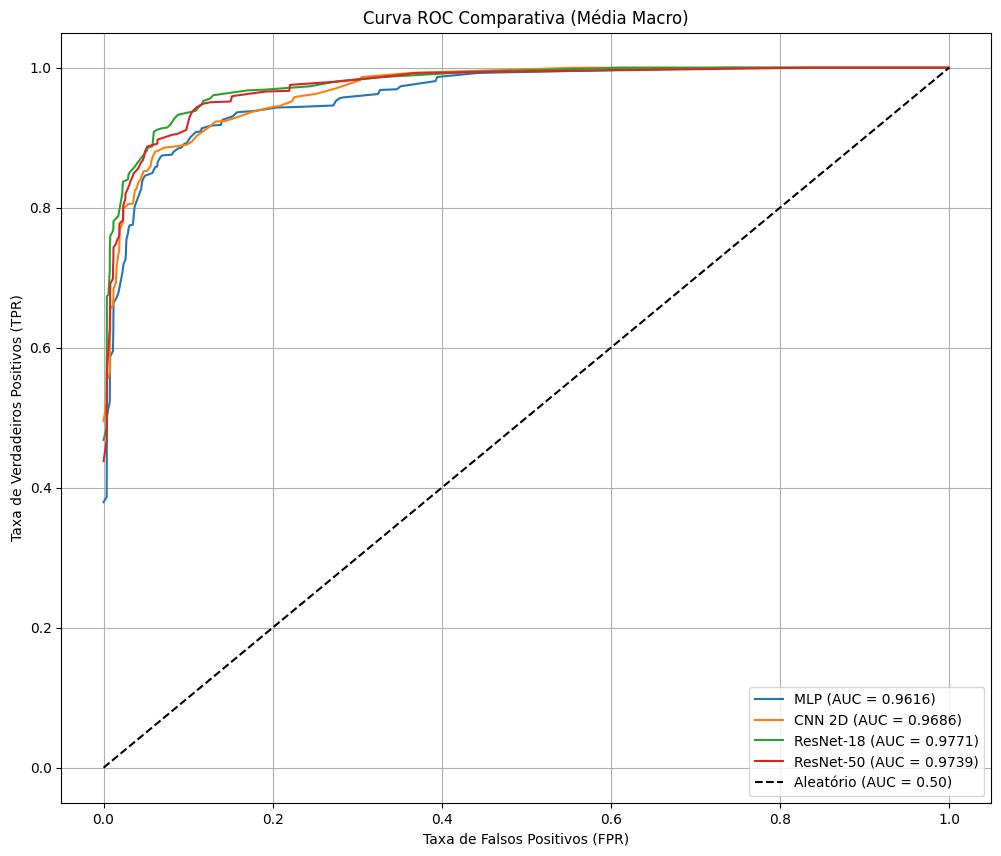

\n--- Scores AUC (Média Macro) para a Tabela ---
MLP: 0.9616
CNN 2D: 0.9686
ResNet-18: 0.9771
ResNet-50: 0.9739


In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import tensorflow as tf

MODELOS_PATH = "/content/drive/My Drive/TCC2-Gabriel/modelos_tcc/"

print("Carregando todos os modelos salvos...")
# Carregar os melhores modelos de cada arquitetura
cnn_model = tf.keras.models.load_model(MODELOS_PATH + 'best_model_cnn.keras')
mlp_model = tf.keras.models.load_model(MODELOS_PATH + 'best_model_mlp.keras')
resnet18_model = tf.keras.models.load_model(MODELOS_PATH + 'best_model_resnet18.keras')
resnet50_model = tf.keras.models.load_model(MODELOS_PATH + 'best_model_resnet50_custom.keras')

models_dict = {
    'MLP': mlp_model,
    'CNN 2D': cnn_model,
    'ResNet-18': resnet18_model,
    'ResNet-50': resnet50_model
}

# Binarizar os labels verdadeiros para a análise ROC multi-classe
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Dicionário para armazenar os scores AUC
auc_scores = {}

plt.figure(figsize=(12, 10))

# Calcular ROC e AUC para cada modelo
for model_name, model in models_dict.items():
    print(f"Calculando predições para o modelo: {model_name}")
    y_pred_prob = model.predict(test_ds)

    # Calcular ROC e AUC para cada classe (abordagem One-vs-Rest)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular a média macro da AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

    macro_roc_auc = auc(all_fpr, mean_tpr)
    auc_scores[model_name] = macro_roc_auc

    # Plotar a curva ROC (média macro)
    plt.plot(all_fpr, mean_tpr, label=f'{model_name} (AUC = {macro_roc_auc:.4f})')

# Plotar a linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.50)')

plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC Comparativa (Média Macro)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('curva_roc_comparativa.png')
plt.show()

print("\\n--- Scores AUC (Média Macro) para a Tabela ---")
for model_name, score in auc_scores.items():
    print(f"{model_name}: {score:.4f}")